# Modelling Temperature using the Ornstein-Uhlenbeck process

Ornstein-Uhlenbeck process is a stochastic process, which can be considered as a random walk with specific property such that there is a tendency for the walk to drift back towards a centre.
The continuous-time O-U process can be define as: $$dT_t = θ(µ_t - T_t)*dt + σdW_t$$where<br>
* $dT_t$ is the change in temperature at time $t$
* $θ$ is the rate of mean reversion (i.e. how strong the attraction back towards the central value is)
* $µ_t$ is the mean temperature at time $t$ (i.e. the temperature trend at time $t$)
* $dt$ is an infinitesimally small time step
* $dW_t$ is a random shock (Browian motion)
* $σ$ is volatility scale factor

## Accessing Temperature Data
The daily temperature data in Waddington, Lincolnshire is accessed from [MIDAS Open: UK Temperature Data v202407](https://catalogue.ceda.ac.uk/uuid/b7c6295b72c54fa9bcd8308fea2727e7/). Although MIDAS data from 2021 are available (which can be seen in `data` folder), the model will be fitted using data from 2000 until 2020, such that data from 2021 onwards can be used for testing the extrapolation.

In [205]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_theme(style="ticks", font_scale=0.8)

all_data = []
for i in range(2000, 2021):
    with open(f'data/raw data/midas-open_uk-daily-temperature-obs_dv-202507_lincolnshire_00384_waddington_qcv-1_{i}.csv') as file:
        if i == 2000: year_data = file.readlines()[93:-1]
        else: year_data = file.readlines()[94:-1]
        for record in year_data: all_data.append(record)

try: 
    file = open('data/waddington_daily_temp_2000-2020.csv','x') # if a csv file for all data does not already exist, create one
    file.close() 
except:
    file = open('data/waddington_daily_temp_2000-2020.csv','w+') # otherwise, clear it
    file.close() 

with open('data/waddington_daily_temp_2000-2020.csv','a') as file: # write in the data
    for record in all_data: 
        file.write(record)
        
df_raw = pd.read_csv('data/waddington_daily_temp_2000-2020.csv')


## Organising the data
Data of February 29's in leap years are omitted for simplicity

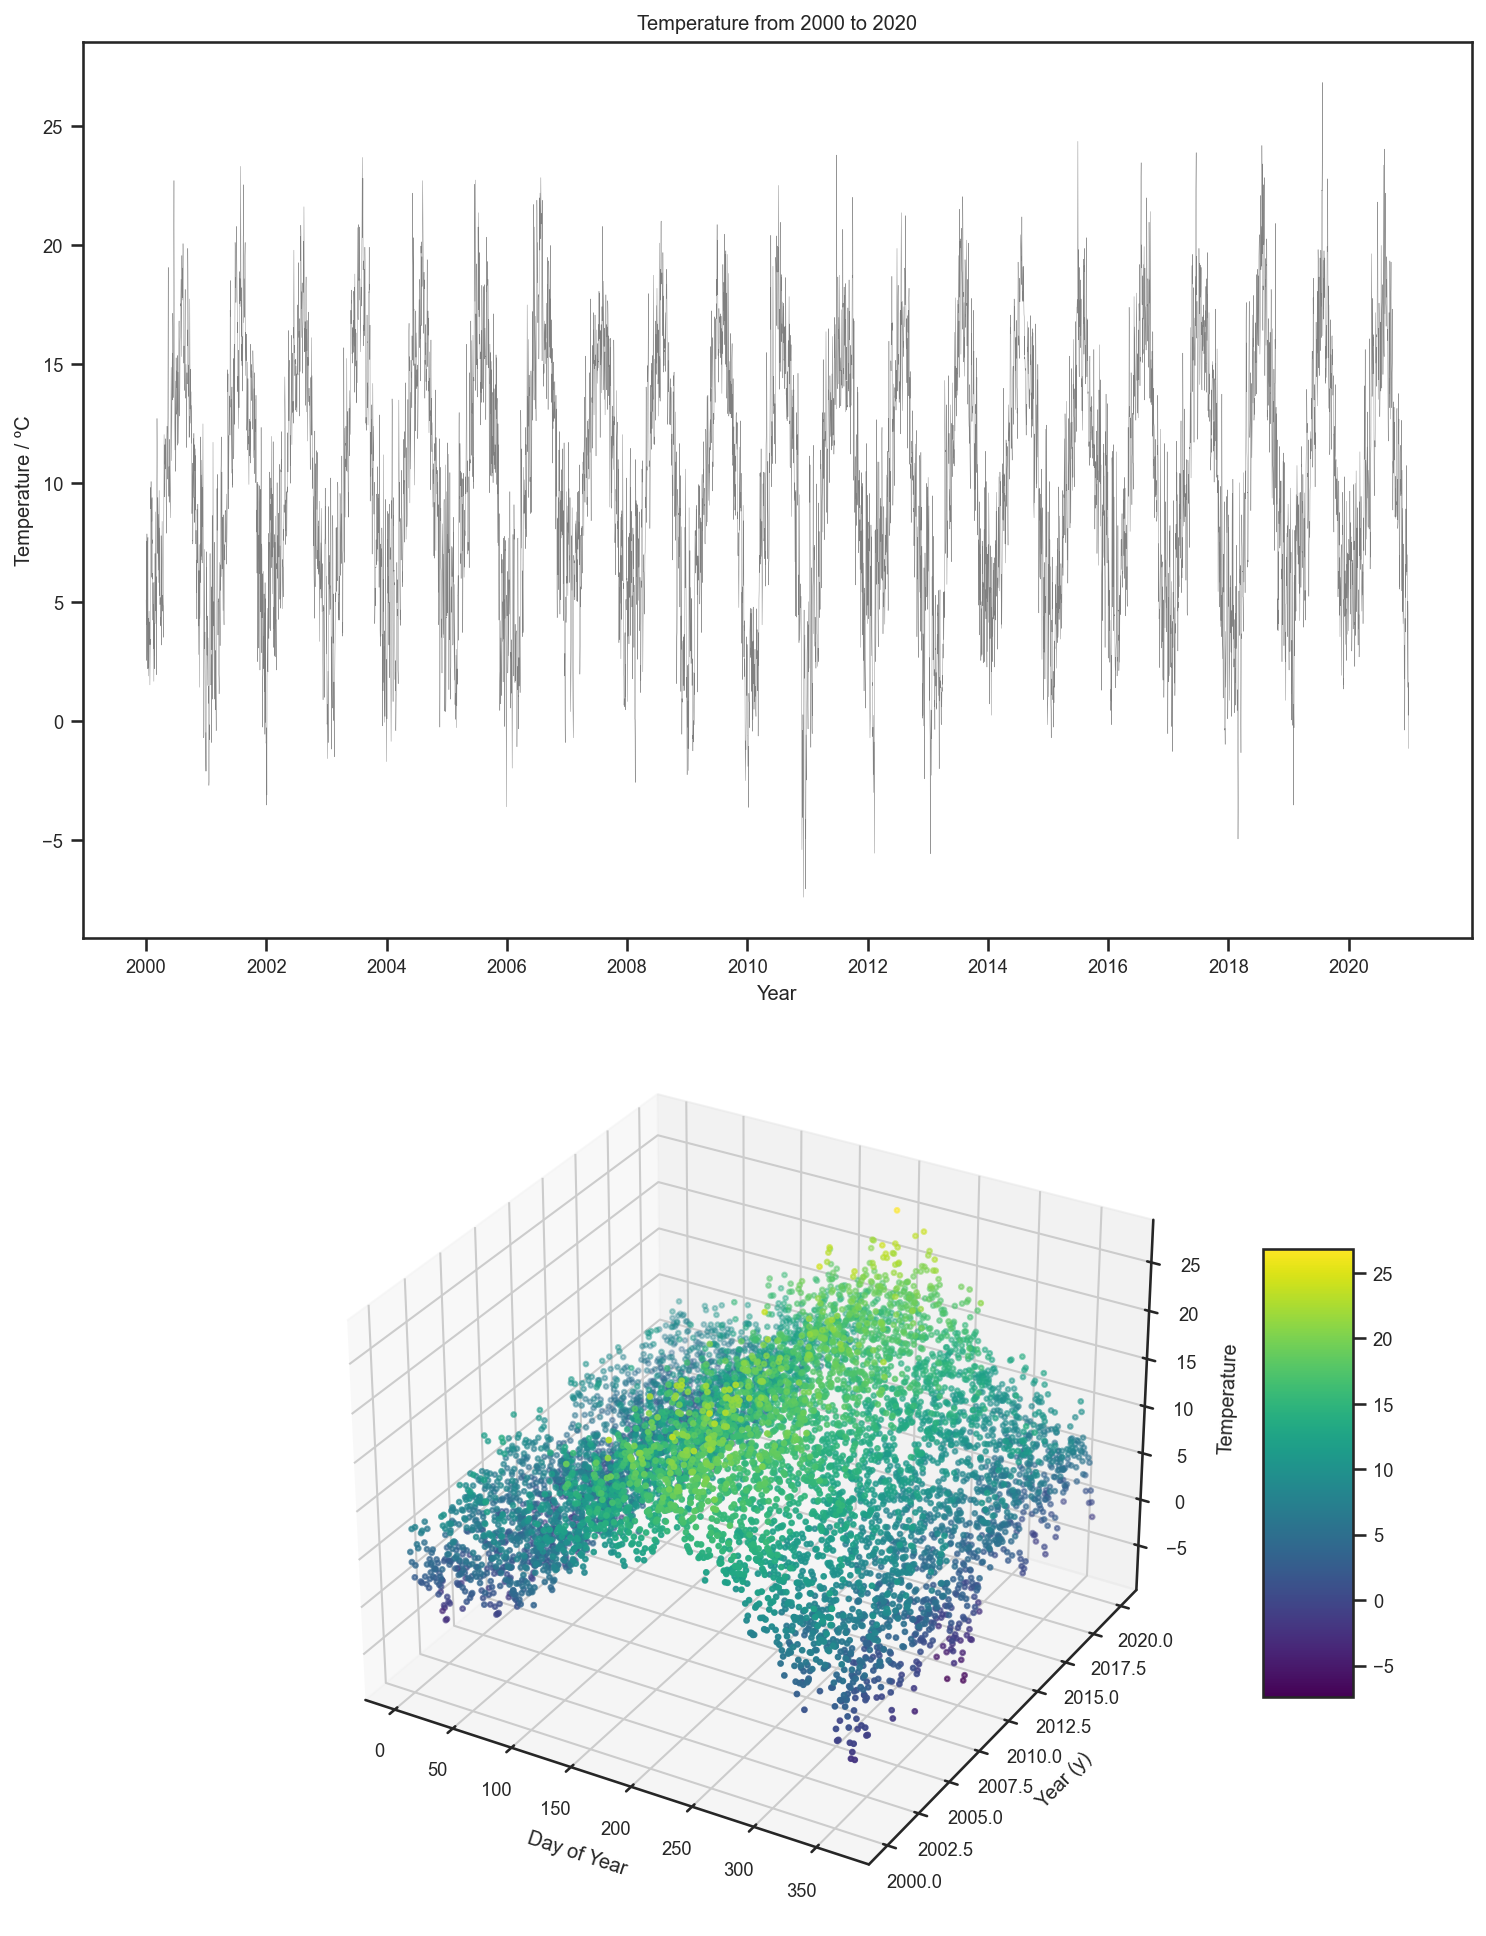

In [206]:
# Checking if data is clean
# There should be two sets of data for each day - e.g. Jul 1 daytime (9AM - 9PM) and Jul 1 (9PM - 9AM+1)
dates_in_data = df_raw['ob_end_time'].tolist()
dates_in_date_range = pd.date_range(start="2000-01-01",end="2020-12-31").tolist()

all_dates = []
for date in dates_in_date_range:
    all_dates.append(str(date).strip(' 00:00:00') + ' 09:00:00')
    all_dates.append(str(date).strip(' 00:00:00') + ' 21:00:00')

# print(len(dates_in_data), len(all_dates))     OUTPUT: 18267 18264
# print(len(set(dates_in_data)), len(set(all_dates)))     OUTPUT: 18264 18264
# This implies there are three duplicates of dates

s = set()
dup = []
for n in dates_in_data:
    if n in s: 
        dup.append(n)
    else:
        s.add(n)
# dup : ['2002-02-14 09:00:00', '2002-02-25 09:00:00', '2019-02-06 09:00:00']
# Turns out there are 3 records with ob_hour_count of 24 rather than 12 which are redundant 
# We will remove these records - i.e. only select those with ob_hour_count=12

df_raw = df_raw[df_raw['ob_hour_count']==12]
df_raw = df_raw[['ob_end_time', 'max_air_temp', 'min_air_temp']]

x = []
for i in range(0, len(df_raw), 2): # Organise data into daily
    x.append([df_raw['ob_end_time'].iloc[i], 1/4 * (df_raw['max_air_temp'].iloc[i] + df_raw['min_air_temp'].iloc[i] + df_raw['max_air_temp'].iloc[i+1] + df_raw['min_air_temp'].iloc[i+1])]) 


# Also to make the model simpler we remove Feb 29's

df_daily = pd.DataFrame(x, columns=['date', 'temp'])
df_daily = df_daily[~((pd.to_datetime(df_daily['date']).dt.month == 2) & (pd.to_datetime(df_daily['date']).dt.day == 29))]


lst = []
t = 0
y = 2000
day_of_year = 0

for row in df_daily.itertuples():
    t += 1
    if row.date[0:4] == str(y): day_of_year += 1
    else: 
        day_of_year = 1
        y += 1
    temp = row.temp
    lst.append([t, y, day_of_year, temp])


df = pd.DataFrame(lst, columns=['t','y','day_of_year','temp'])

fig = plt.figure(figsize=(10,13))# Create a new figure

ax1 = fig.add_subplot(211)
ax1.plot(df['temp'], c='grey', linewidth=0.2)
ax1.set_title("Temperature from 2000 to 2020")
ax1.set_xticks([i*365*2 for i in range(0, 11)], [y for y in range(2000, 2021, 2)])
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature / ºC')

ax2 = fig.add_subplot(212, projection='3d') # Add a 3D subplot
scat = ax2.scatter(df['day_of_year'], df['y'], df['temp'], c=df['temp'], cmap='viridis', s=5)
ax2.set_xlabel('Day of Year')
ax2.set_ylabel('Year (y)')
ax2.set_zlabel('Temperature')
fig.colorbar(scat, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

## 1. Defining an additive model
Define our temperature data T(t) to an additive model:
$$T(t) = F(t) + G(t) + \epsilon(t)$$ where,
* $f(t)$ is the change in seasonality, $t ∈ [1, 365]$;
* $g(t)$ is the year-on-year trend, $t ∈ [1, 7665]$;
* $\epsilon(t)$ is the residuals, i.e. random variation in the data

Reference: [YouTube - QuantPy - Detrending and deseasonalizing data with fourier series](https://www.youtube.com/watch?v=sa7E9qUHYXw)

## 2. Fitting f(t) with Fourier Series
To isolate the seasonality component, we collapse temperature curves of each year across all years.
$$\overline{T(t)} = \frac{T_{2000}(t) + T_{2001}(t) +\:...\:+ T_{2020}(t)}{21}$$
Then, $\overline{T(t)}$ is fit using truncated Fourier series to model it as:
$$\overline{T(t)} ≈ F(t) = a_0 + a_1\:cos (\frac{2πt}{365}) + b_1\:sin (\frac{2πt}{365}) + a_2\:cos (\frac{4πt}{365}) + b_2\:sin (\frac{4πt}{365}) +\:...$$
$$= a_0 + \sum_{k=1}^{K} \:[a_k\:cos (\frac{2πkt}{365}) + b_k\:sin (\frac{2πkt}{365})]$$ where,
* $F(t)$ is the obtained fit for the seasonality component
* $K$ is the number of harmonics ('terms')
* $a_0$ is the intercept
* $a_k$ and $b_k$ are Fourier coefficients to be found.
Fourier series is effective in describing periodic functions like seasonality. With an explicit formula as above obtained, extrapolation into future years is straightforward.

### Acquiring the Fourier coefficients
We first draw a curve of best fit through the $\overline{T(t)}$ plots as an approximation of the Fourier series to be found. This is done using a Gaussian filter to 'smooth' the data points by averaging neighbouring data points (with weightings to each data points according to a Gaussian kernel).
With the smooth curve, Fourier coefficients are able to be calculated using the formulae below:
$$a_0 = \frac{1}{2L} \int_{-L}^{L} f(x)\:dx$$
$$a_k = \frac{1}{2L} \int_{-L}^{L} f(x)\:\cos\:(\frac{kx\pi}{L})\:dx$$
$$b_k = \frac{1}{2L} \int_{-L}^{L} f(x)\:\sin\:(\frac{kx\pi}{L})\:dx$$ where,
* L is half the period of the function (in this case $L = \frac{365}{2}$)<br>

We choose to use three harmonics as it is generally sufficient in modelling temperature curves (in fact, in many studies of temperature modelling, one harmonic is considered adequate and used)

Reference: [Mathisfun.com - Calculus - Fourier Series](https://www.mathsisfun.com/calculus/fourier-series.html)

10.151592464839737 [-5.985721730597032, 0.10309640602066157, -0.0009171876586573527] [-2.5583471091648753, 0.5402362343579853, 0.02717039192035989]


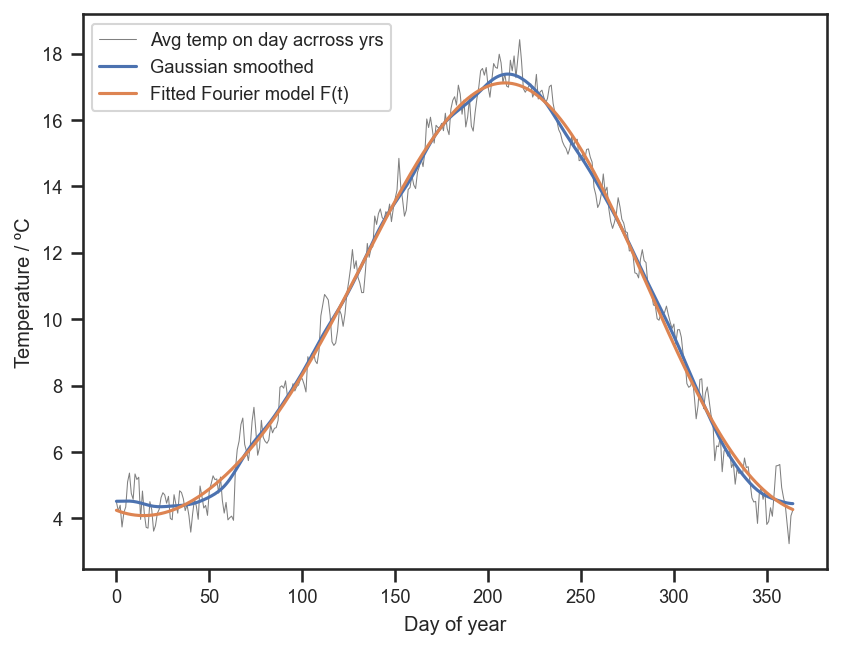

In [207]:
# Code for [2]
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter

list_temp_seasonal_component = []
for day_of_year in range(1, 366):
    new_row = {'day_of_year': day_of_year, 'avg_temp_across_y': sum(df[df['day_of_year']==day_of_year]['temp'].values)/21}
    list_temp_seasonal_component.append(new_row)

df_temp_seasonal_component = pd.DataFrame(list_temp_seasonal_component)
plt.plot(df_temp_seasonal_component['avg_temp_across_y'], label='Avg temp on day acrross yrs', c='grey', linewidth=0.5)

#df_temp_seasonal_component['savgol_smoothed'] = savgol_filter(df_temp_seasonal_component['avg_temp_across_y'], window_length=30, polyorder=1)
#plt.plot(df_temp_seasonal_component['savgol_smoothed'])

df_temp_seasonal_component['gaussian_smoothed'] = gaussian_filter(df_temp_seasonal_component['avg_temp_across_y'], sigma=8)
plt.plot(df_temp_seasonal_component['gaussian_smoothed'], label='Gaussian smoothed')

K = 3 # Number of harmonics
L = 365/2
T_t = df_temp_seasonal_component['gaussian_smoothed'].values
t = df_temp_seasonal_component['day_of_year'].values
t_centered = t - L # to centre time from [1, 365] to [-L, L]
a_0 = (1/(2*L)) * np.trapz(T_t)
a_k = []
b_k = []
for k in range(1,K+1):
    a_k.append((1/L) * np.trapz(T_t * np.cos(k * t * (np.pi/L)), t_centered))
    b_k.append((1/L) * np.trapz(T_t * np.sin(k * t * (np.pi/L)), t_centered))

F_t = [a_0 for i in range(365)]
for k in range(1, K+1):
    F_t += a_k[k-1] * np.cos(2 * np.pi * k * t / 365) + b_k[k-1] * np.sin(2 * np.pi * k * t / 365)

print(a_0, a_k, b_k)
df_temp_seasonal_component['F(t)'] = pd.DataFrame(F_t)
df['F(t)'] = pd.DataFrame(F_t.tolist() * 21)
plt.plot(df_temp_seasonal_component['F(t)'], label='Fitted Fourier model F(t)')
plt.xlabel('Day of year')
plt.ylabel('Temperature / ºC')
plt.legend()
pass

$$\therefore F(t) = 10.1516 + -5.9857\:cos (\frac{2πt}{365}) + -2.5583\:sin (\frac{2πt}{365}) + 0.1031\:cos (\frac{4πt}{365}) + 0.5402\:sin (\frac{6πt}{365}) + -0.0009\:cos (\frac{6πt}{365}) + 0.0272\:sin (\frac{6πt}{365})$$

## 3. Extract $G(t)$ using linear regression
Use ordinary least squares method to model a linear trend $G(t) = mt + c$ for the interannual trend.

LinregressResult(slope=5.033183250642959e-05, intercept=-0.18064614661248551, rvalue=0.040965704690966456, pvalue=0.0003339049617229346, stderr=1.4023556859305987e-05, intercept_stderr=0.06206577801718549)
Approx. 0.386ºC warming from 2000 to 2020


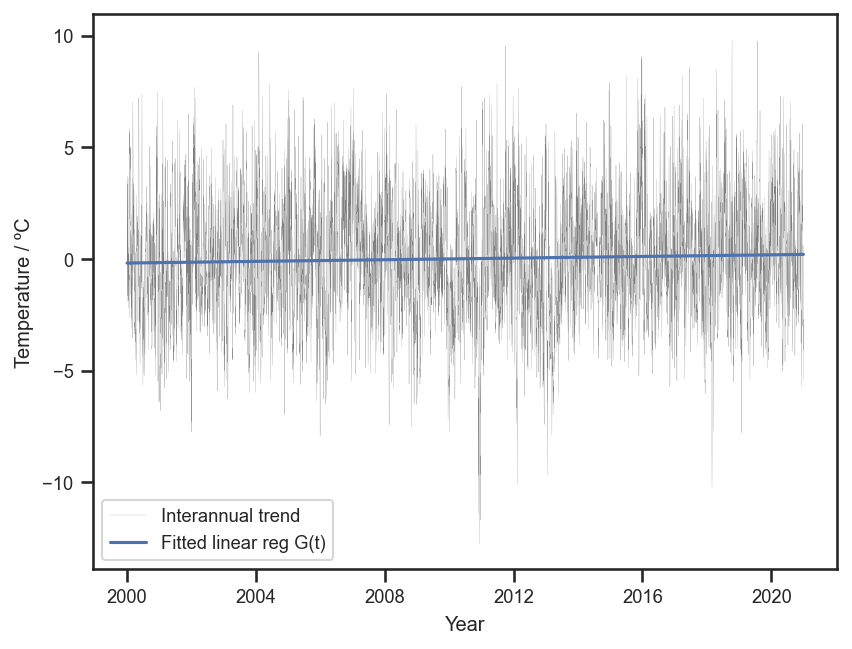

In [208]:
# Code for [3]
from scipy.stats import linregress
df_interannual_trend_component = pd.DataFrame([])
df_interannual_trend_component[['t','y','day_of_year']] = df[['t','y','day_of_year']]
df_interannual_trend_component['interannual_trend'] = df['temp'] - df['F(t)']
linear_reg = linregress(df_interannual_trend_component['t'], df_interannual_trend_component['interannual_trend'])

m = linear_reg.slope
c = linear_reg.intercept 
df_interannual_trend_component['G(t)'] = m * df_interannual_trend_component['t'] + c
df['G(t)'] = m * df_interannual_trend_component['t'] + c

plt.plot(df_interannual_trend_component['interannual_trend'], label='Interannual trend', c='grey', linewidth=0.1)
plt.plot(df_interannual_trend_component['G(t)'], label='Fitted linear reg G(t)')
plt.xticks([i*365*4 for i in range(0, 6)], [y for y in range(2000, 2021, 4)])
plt.xlabel('Year')
plt.ylabel('Temperature / ºC')
plt.legend()
print(linear_reg)
print(f'Approx. {(m * 365 * 21):.3f}ºC warming from 2000 to 2020')


$5.0332 * 10^{-5}\:ºC$ per day on average $*\:365$ days $= 0.01837ºC$ per year on average<br>
$\implies$ approx. $0.386ºC$ from 2020 to 2021,
which is consistent with literature.

## 4. Derived equation for mean temperature curves $µ(t)$
With coefficients for $F(t)$ and $G(t)$ obtained, $µ(t)$ is derived as below for extrapolation into future years
$$ F(t) = 10.1516 + -5.9857\:cos (\frac{2πt}{365}) + -2.5583\:sin (\frac{2πt}{365}) + 0.1031\:cos (\frac{4πt}{365}) + 0.5402\:sin (\frac{6πt}{365}) + -0.0009\:cos (\frac{6πt}{365}) + 0.0272\:sin (\frac{6πt}{365})$$
$$ G(t) = 5.0332 \times 10^{-5}t - 0.1806$$
$$µ(t) = F(t) + G(t)$$

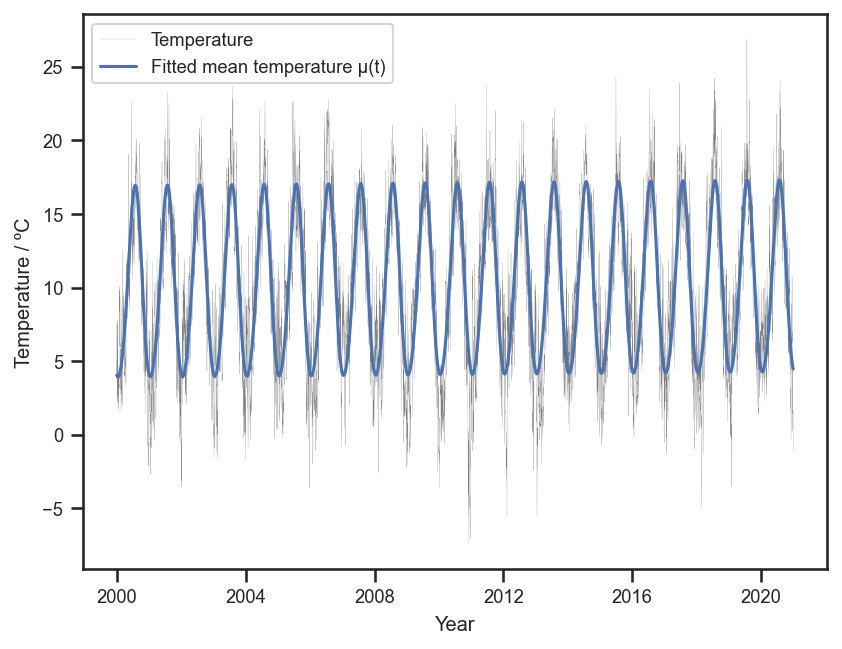

In [209]:
df['µ(t)'] = df['F(t)'] + df['G(t)']
plt.plot(df['temp'], label='Temperature', c='grey', linewidth=0.1)
plt.plot(df['µ(t)'], label='Fitted mean temperature µ(t)')
plt.xticks([i*365*4 for i in range(0, 6)], [y for y in range(2000, 2021, 4)])
plt.xlabel('Year')
plt.ylabel('Temperature / ºC')
plt.legend()
pass

To evaluate the reliability of the model, we can use the equation $$R^2 = 1 - \frac{Total\:sum\:of\:squares}{Residual\:sum\:of\:squares}$$ we can assess how well the model explains the variation in the temperature data.

In [210]:
df['residual(t)'] = df['temp'] - df['µ(t)']
rss = np.sum((df['temp'] - df['µ(t)'])**2) 
tss = np.sum((df['temp'] - df['temp'].mean())**2)

r_squared = 1 - (rss / tss)
r_squared

0.7455665164253198

With an $R^2$ value of ~$0.746$, we can conclude that our model is able to explain about 74.6% of variation in the temperature data.

## 5. Examining the residuals
Below is a graph of the residuals $\epsilon(t) = T(t) - F(t) - G(t)$:

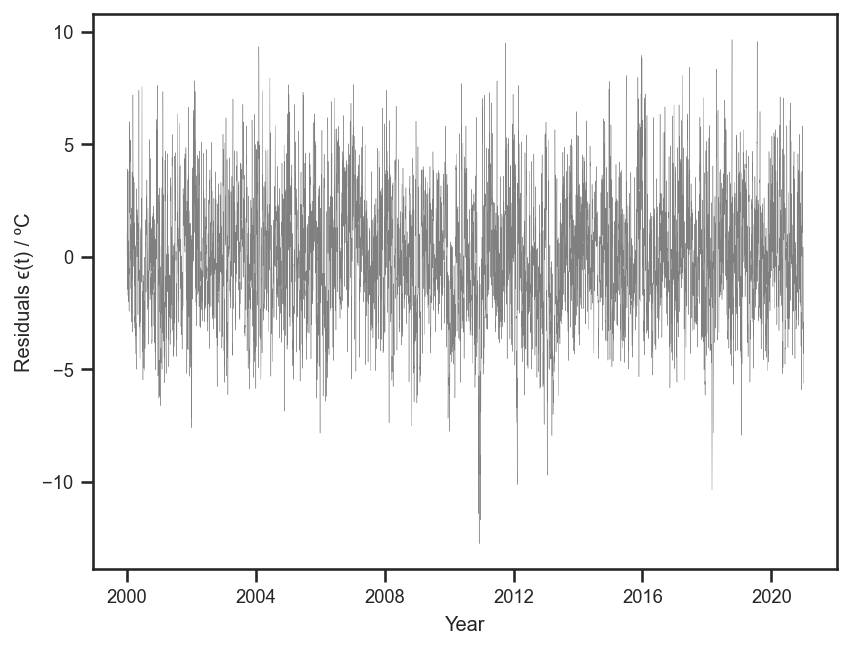

In [211]:
plt.plot(df['residual(t)'], c='grey', linewidth=0.2)
plt.xticks([i*365*4 for i in range(0, 6)], [y for y in range(2000, 2021, 4)])
plt.xlabel('Year')
plt.ylabel('Residuals ϵ(t) / ºC')
pass

"If 3ºC above the expected temperature is measured today, is tomorrow more likely to be hotter than the expected temperature too? By how much?"

To answer the question, we examine and plot the correlations between residual of time $t$, and the residual of time $(t-k)$ ('lagged residual'), in the ACF plot below. This is essential to estimate $\theta$ (the rate of mean reversion) and $\omega$ (volaility) in the O-U equation to keep our future simulations accurate.

Reference: [YouTube - ritvikmath - Time Series Talk : Autocorrelation and Partial Autocorrelation](https://www.youtube.com/watch?v=DeORzP0go5I)

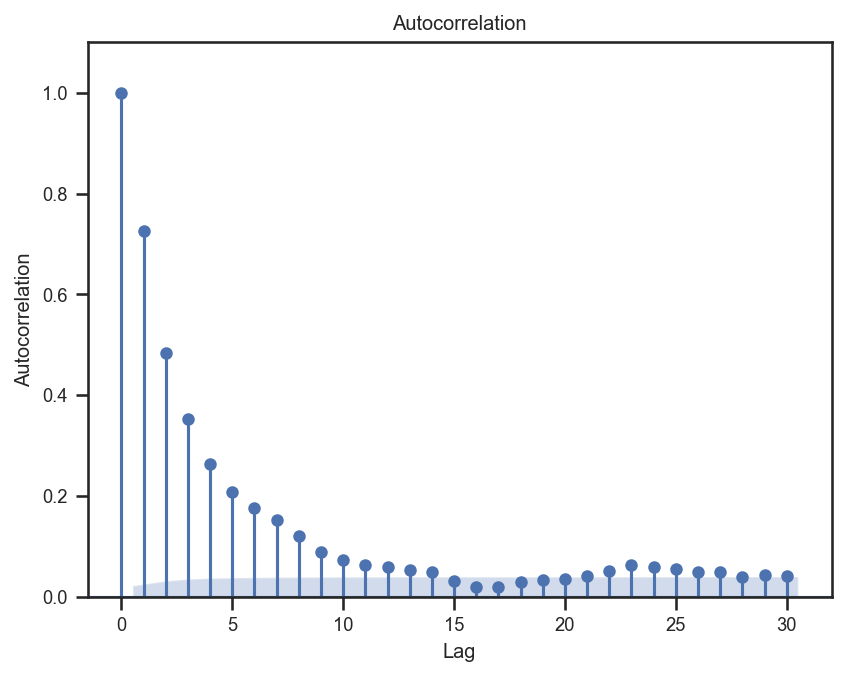

In [212]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['residual(t)'], lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.ylim(0, 1.1)
pass

Below, the PACF plot shows that since correlation coefficients at lags $k > 1$ are negligable, showing that our model is of order AR(1). This confirms we can ignore higher AR terms.

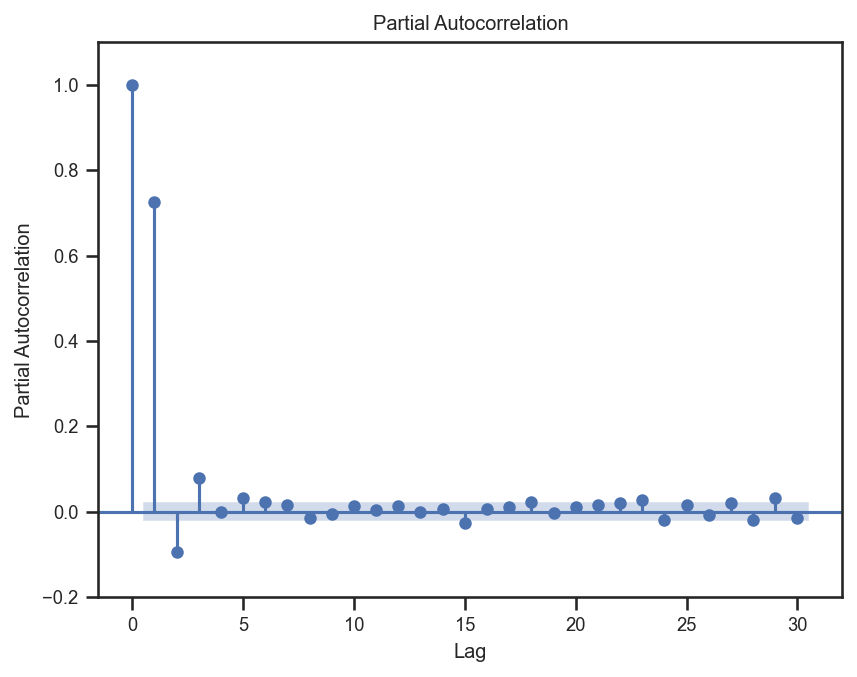

In [213]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['residual(t)'], lags=30)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.ylim(-0.2, 1.1)
pass

## 6. Fitting a model to the residuals, and finding $\theta$ and $\sigma$
Plotting the lagged residuals $\epsilon_{t-1}$ against residuals $\epsilon_t$, we extract $\phi$ and $\eta$ described in the following equation:
$$\epsilon_{t} = \phi\:\epsilon_{t-1} + \eta_t$$
where,
* $\phi$ is the persistance (how much the lagged residual affects the residual) - slope of the regression, and
* $\eta_t$ is the 'white noise' (unexplained part of the residual, after accounting for the lagged residual) - vertical distance of a point from the regression line

ϕ = 0.7271297725208313


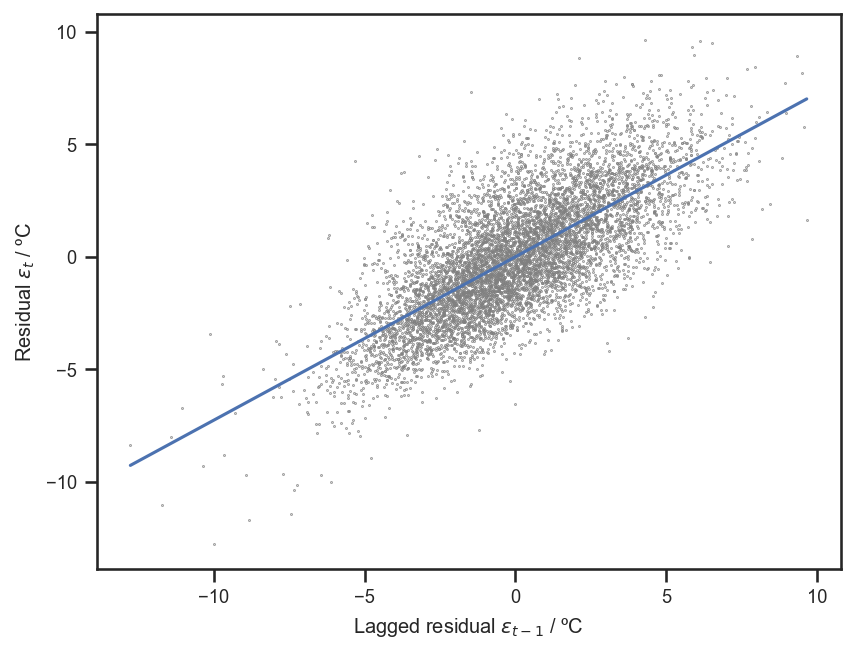

In [214]:
from scipy.stats import linregress

df['residual(t-1)'] = df['residual(t)'].shift(1)
plt.scatter(df['residual(t-1)'], df['residual(t)'], c='grey', s=0.1)
plt.xlabel('Lagged residual $\\varepsilon_{t-1}$ / ºC')
plt.ylabel('Residual $\\varepsilon_t$ / ºC')

linear_reg = linregress(df['residual(t-1)'].iloc[1:], df['residual(t)'].iloc[1:]) 
persistance = linear_reg.slope
c = linear_reg.intercept
X = np.linspace(df['residual(t-1)'].min(), df['residual(t-1)'].max(), 200)
Y = persistance*X + c
plt.plot(X, Y)
print(f'ϕ = {persistance}')

pass

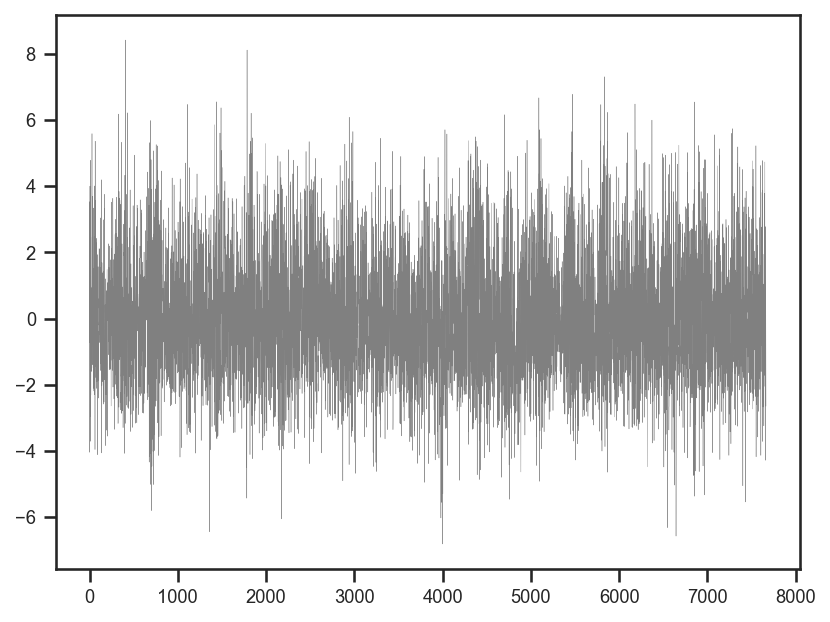

In [215]:
df['white_noise(t)'] = df['residual(t)'] - persistance * df['residual(t-1)']
plt.plot(df['white_noise(t)'], c='grey', linewidth=0.2)
pass

With $\phi$ estimated, we can find $\theta$ (the rate of mean reversion) and $\sigma$ (volatility) using the equations below:
$$\theta \approx -\frac{\ln(\phi)}{\Delta t}$$
$$\sigma \approx \sqrt{\frac{\sigma^2_{\eta}}{\Delta t}}$$
where $\sigma^2_{\eta}$ is the mean squared error of $\{\eta_t\}$. 

Reference: [Mean-Reverting Spread Modeling: Caveats in Calibrating the OU Process](https://hudsonthames.org/caveats-in-calibrating-the-ou-process/)

In [216]:
delta_t = 1
rate_of_mean_rev = -np.log(persistance)/delta_t
vol = np.sqrt(np.mean(df['white_noise(t)'].iloc[1:]**2)/delta_t)
'Rate of mean reversion:', rate_of_mean_rev, 'Volatility:', vol

('Rate of mean reversion:',
 0.31865031322338744,
 'Volatility:',
 1.8654151104371786)

The last bit of the O-U process is $dW_t$ – the increment of the Wiener process (Brownian motion). We know:
$$dW_t \sim \mathcal{N}(0, dt)$$


## 7. Simulating the O-U process
Instead of the continuous O-U process $$dT_t = θ(µ_t - T_t)\cdot dt + σdW_t$$we can use the Euler–Maruyama discretised version for simulation:
$$T_{t+\Delta t} = T_t + \theta(\mu_{t+\Delta t} - T_t)\cdot\Delta t + \sigma dW_t$$

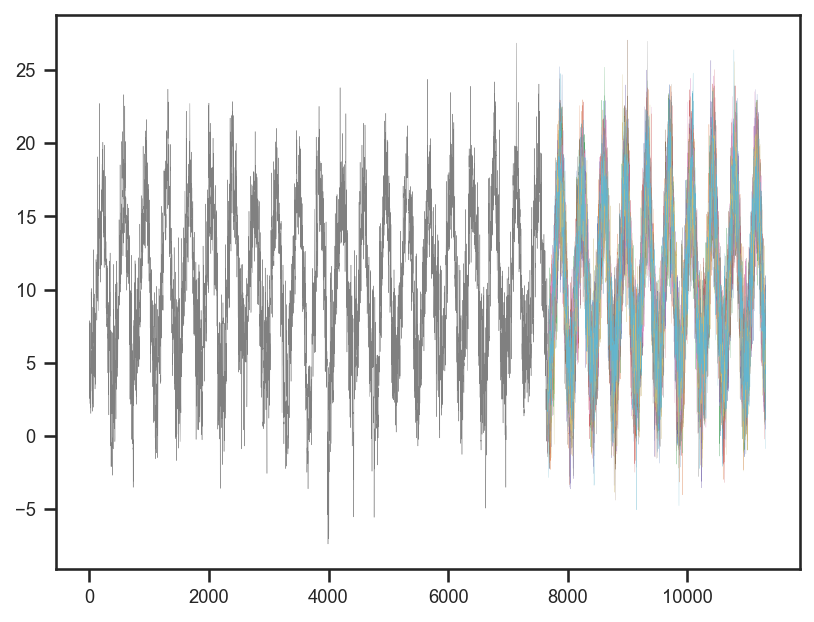

In [217]:
df_sim = pd.DataFrame()
df_sim['t'] = pd.DataFrame([i for i in range(365*21+1, 365*31+1)])
df_sim['y'] = pd.DataFrame([y for y in range(2021, 2031) for i in range(365)])
df_sim['day_of_year'] = pd.DataFrame([i for y in range(10) for i in range(1, 366)])
df_sim['F(t)'] = df['F(t)']
df_sim['G(t)'] = 5.0332*10**-5*df_sim['t'] - 0.1806
df_sim['µ(t)'] = df_sim['F(t)'] + df_sim['G(t)']

df_sim = pd.concat([df.tail(1)[['t', 'y', 'day_of_year', 'F(t)', 'G(t)', 'µ(t)']], df_sim], ignore_index=True)

for n in range(1,11):
    df_sim[f'path_{n}'] = np.zeros(3651)
    for t_plus_one in range(1, 365*10+1):
        T_t = df_sim[f'path_{n}'].iloc[t_plus_one - 1]
        dW_t = np.sqrt(delta_t) * np.random.normal(0, 1)
        µ_tplusone = df_sim['µ(t)'].iloc[t_plus_one]
        
        T_tplusone = T_t + rate_of_mean_rev * (µ_tplusone - T_t) * delta_t + vol * dW_t
        df_sim.loc[t_plus_one, f'path_{n}'] = T_tplusone

        
plt.plot(df['t'], df['temp'], c='grey', linewidth=0.2)

for n in range(1,11):
    plt.plot(df_sim['t'], df_sim[f'path_{n}'], linewidth=0.1)

pass